# Topical Lectures April 2021
## Drone control, part 2: system identification
Andreas Freise, Bas Swinkels 13.04.2021

Before we can start playing with control systems for our drone we need to first understand the drone itself a bit better. Each drone comes with roughly the same specification but the exact behaviour of each individual model is slightly different. For example, the left and right motors are not providing the exact same force when the same voltage is applied. Similarly they most likley won't have the same full range (V_min to V_max). 

We need to do some experiments to find the parameters that characterise our drone, so that we can compensate for such deviations in the actuation part of our control system.

First we learn how to do such experiments:
- from now on you need to call the ```drone``` command without the ```test``` paramater. Instead you have to specfify your full name, e.g. in my case :
 - ```MyName = "Andreas"```
 - ```drone = module.Drone(name=MyName)```. 
The name string is used to generate unique parameters for your drone. 
- The drone has two optional parameters: ```wind``` and ```flight_range```: ```wind``` is a Boolean variable, when ```True``` the drone experiences random external forces from airmotion. For the system identifcation we assume we are somewhere inside withour wind and can set ```wiind=False```. 
- We will use the ```flight_range``` extensively. It is an array of 4 values giving the lower left and upper right coordinates of the free range in which the drone can fly. This can be also used to `clmap' the drone in a jig for testing. For example, with ```flight_range=[0,0,0,0]``` the drone will not move sideways or up/down, but can still tilt. Similarly, using ```flight_range=[0,-500,0,500]``` linits the drone to up/down motion (tilt remains allowed).

In this notebook we will experiments in non-interactive way. You need to think ahead and plan your experiment and analyse the output afterwards. In practise this means you need to allocate an empty NumPy array to store the results, i.e. you have to decide in advance how mnay iterations you want to run. Let's try it out:

In [554]:
import numpy as np
import matplotlib.pyplot as plt
import time
import module
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# This time we want inline plotting (non-interactive)
%matplotlib inline

# Don't forget to set the name string to your own name
MyName = "Joran"

In [555]:
# First: just see how we can do some plotting without the interactve graph

drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])

N = 3000 # number of iterations

# Allocating a NumPy array for our data, with N rows and 14 columns, of which 
# 12 column will be used to store drone output, and 2 columns for other data
results = np.zeros([N,14])

# The drone will return 12 values:
# t, y, z, phi, y', z', phi', F, tau, F_left, F_right, targets_achieved
# t: time
# y: y (left-right) position in cm
# z: z (up-down) position in cm
# phi: angle of the drone in radians
# y' ,z' ,phi' are the respective velocities
# F: total force
# tau: torque
# force applied in left motor
# force applied in right motor
# targets_achieved: number of targets succesfully reached (in the right order)

# We will use the results array cto store two further values:
# the voltage we send to the left and right rotor.

V_left, V_right = (0.4937349449816612, 0.5048349449816606)

for i in range(N):
    # each iteration we can set the voltage of the motors
    drone.set_V(V_left, V_right)
    # the update functions performas one iteration of 1/60 s duration and returns the state of the drone
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right] # append voltages just to record everything


In [556]:
V_left, V_right

(0.4937349449816612, 0.5048349449816606)

Now we can plot what happened in our experiment:

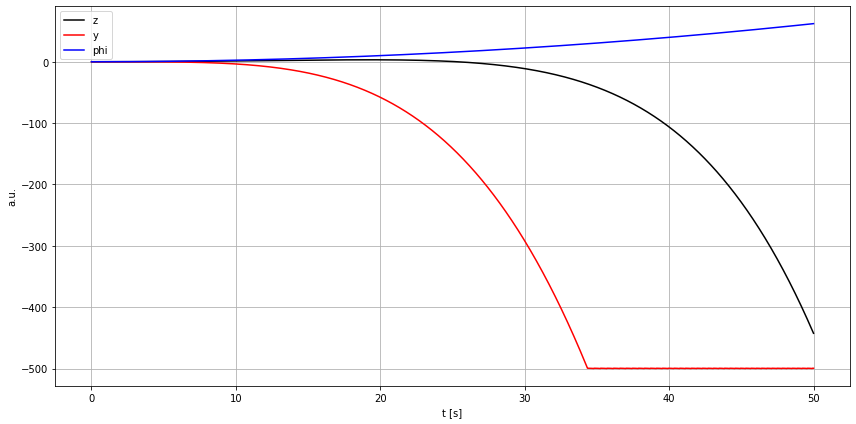

In [557]:
# plotting the y,z position and tilt of the drone as a function of time 
t = results[:,0]
y = results[:,1]
z = results[:,2]
phi = results[:,3]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t,z, 'k', label="z")
plt.plot(t,y, 'r', label="y")
plt.plot(t,np.rad2deg(phi), 'b', label="phi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

We see that without any corrections our drone rolls and falls. 

Next, we should try to stabilise the tilt by finding the right volatges for the left and right rotors to balance the forces. We can find the right voltages, for eample, by ramping the voltage of one rotor during the experiment and then check when the acceleration of the tilt (phi'') becomes zero.

In [558]:
drone = module.Drone(name=MyName, wind=False, flight_range=[0,0,0,0])
N = 800
results = np.zeros([N,14])

V_left =  1
V_right = 1

max_offset = 0.3
V_left_offset = -1 * max_offset

for i in range(N):
    # ramping the left voltage
    V_left_offset += 2.0 * max_offset / N
    drone.set_V(V_left + V_left_offset, V_right)
    results[i,0:12] = drone.update()
    results[i,12] = V_left_offset # this time we store the offset only


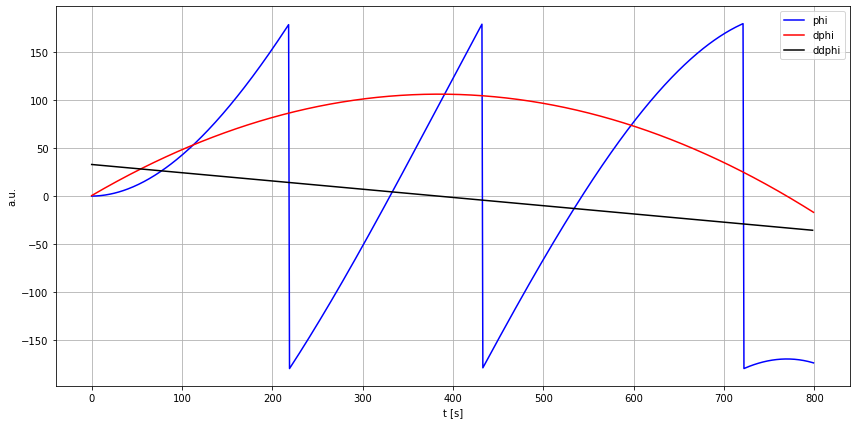

In [559]:
t = results[:,0]
y = results[:,1]
z = results[:,2]
phi = results[:,3] # angle
dphi = results[:,6] # angular velocity
ddphi = np.diff(dphi)/np.diff(t) # angular acceleration phi'' (derivative of phi')
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(np.rad2deg(dphi), 'r', label="dphi")
plt.plot(np.rad2deg(ddphi), 'k', label="ddphi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

The best way to find a specifc value in an array with Python is the using the ```argmin``` function from NumPy. In this case we want to know when ```ddphi``` is zero, and then get the voltage offset at which this ocured:

In [560]:
idx = np.argmin(np.abs(ddphi-0))
print(f"ddphi = {ddphi[idx]}")

ddphi = -0.00033333333334884094


In [561]:
V_left_offset = results[idx,12]
print(f"V_left_offset  = {V_left_offset}")

V_left_offset  = -0.011250000000001564


(Before continuing, you might want to re-run the above to find a more accurate value for this offset.)

Now we can run the drone usibg the new-found offset and see if we have a more stable (in tilt) drone:

In [562]:
idx = np.argmin(np.abs(ddphi-0))
print(f"ddphi = {ddphi[idx]}")

ddphi = -0.00033333333334884094


In [563]:
V_left+results[idx,12], V_right


(0.9887499999999985, 1)

OK, this should be better alerady. Maybe we could use a more accurate value to balance it even better. It does not need to be perfect as we will use a control loop later.

We suggest as the next experiments:
1) find the voltages for the drone to hover
2) find the maxiumum and minimum voltages that can be safely applied (before one of the rotors stops reacting)

The first of these test could follow the same technique as before, e.g. ramp the voltages together (while using the offset from before to balance the rotors) and find the moment when z'' becomes zero.

In [564]:
V_left, V_right = (0.9887499999999985, 1)

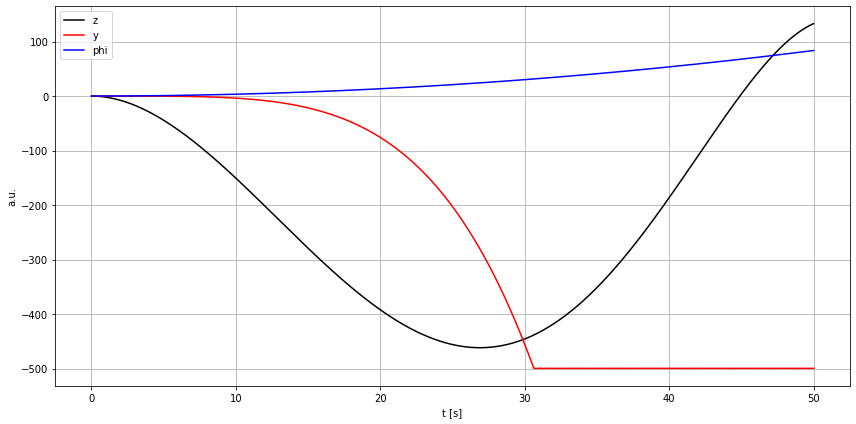

In [565]:

drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])

N = 3000 # number of iterations

# Allocating a NumPy array for our data, with N rows and 14 columns, of which 
# 12 column will be used to store drone output, and 2 columns for other data
results = np.zeros([N,14])
V_hoover = np.linspace(-0.7,0.1,N)

for i in range(N):
    # each iteration we can set the voltage of the motors
    drone.set_V(V_left+V_hoover[i], V_right+V_hoover[i])
    # the update functions performas one iteration of 1/60 s duration and returns the state of the drone
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left+V_hoover[i],V_right+V_hoover[i]]

t = results[:,0]
y = results[:,1]
z = results[:,2]
phi = results[:,3]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t,z, 'k', label="z")
plt.plot(t,y, 'r', label="y")
plt.plot(t,np.rad2deg(phi), 'b', label="phi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

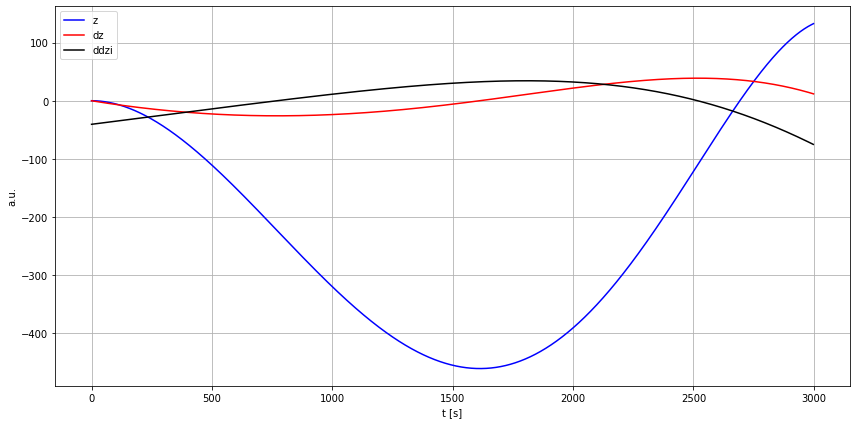

In [566]:
# Plotting the result
t = results[:,0]
z = results[:,2]
dz = results[:,5]
ddz = np.diff(dz)/np.diff(t)
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(z, 'b', label="z")
plt.plot(dz, 'r', label="dz")
plt.plot(10*ddz, 'k', label="ddzi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

In [567]:
idx = np.argmin(np.abs(ddz-0))
print(f"ddz = {ddz[idx]}")
idx

ddz = -0.0007252514699728957


771

In [568]:
# store the result in a variable to use later
V_hover = V_left + V_hoover[idx], V_right + V_hoover[idx]

In [572]:
V_hover

(0.49441855618539365, 0.5056685561853952)

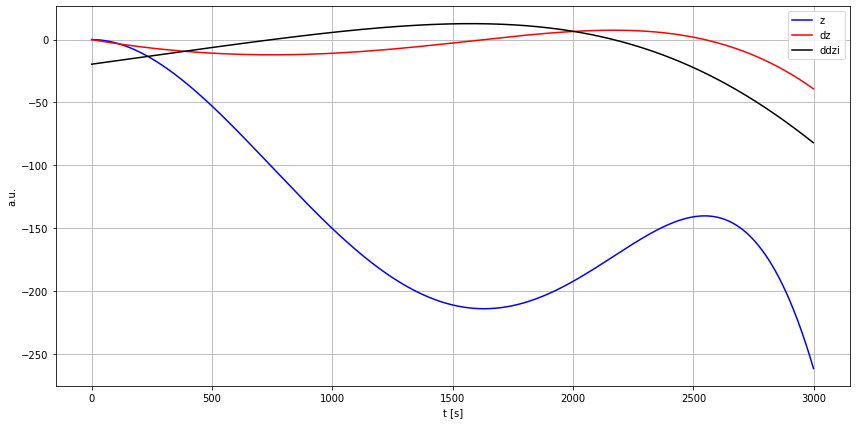

In [586]:

drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])

N = 3000 # number of iterations

# Allocating a NumPy array for our data, with N rows and 14 columns, of which 
# 12 column will be used to store drone output, and 2 columns for other data
results = np.zeros([N,14])
V_hoover = np.linspace(-0.1,0.3,N)

for i in range(N):
    # each iteration we can set the voltage of the motors
    drone.set_V(V_left+V_hoover[i], V_right+V_hoover[i])
    # the update functions performas one iteration of 1/60 s duration and returns the state of the drone
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left+V_hoover[i],V_right+V_hoover[i]]

# t = results[:,0]
# y = results[:,1]
# z = results[:,2]
# phi = results[:,3]
# fig, ax = plt.subplots(1, figsize=(12,6))
# plt.plot(t,z, 'k', label="z")
# plt.plot(t,y, 'r', label="y")
# plt.plot(t,np.rad2deg(phi), 'b', label="phi")
# ax.set_xlabel("t [s]")
# ax.set_ylabel("a.u.")
# plt.grid()
# plt.legend()
# plt.tight_layout()

We can test if the drone stays in the air longer now:

In [574]:
drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])
N = 3000 # number of iterations
results = np.zeros([N,14])

V_left, V_right = V_hover

for i in range(N):
    drone.set_V(V_left, V_right)
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]

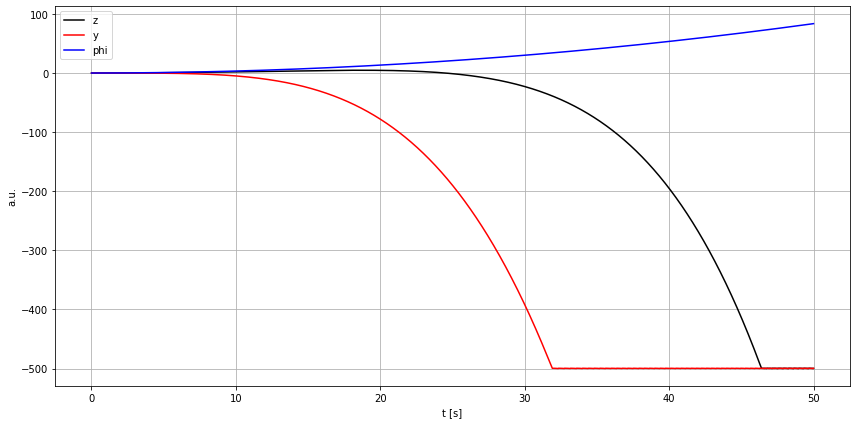

In [575]:
t = results[:,0]
y = results[:,1]
z = results[:,2]
phi = results[:,3]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t,z, 'k', label="z")
plt.plot(t,y, 'r', label="y")
plt.plot(t,np.rad2deg(phi), 'b', label="phi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

Finally we want to check for clipping, i.e. find out what are the maximum and minimum voltages for each motor. We can use this information later to limit the feedback of our control to a safe range.

In [576]:
V_left, V_right = (0.49441855618539365, 0.5056685561853952)

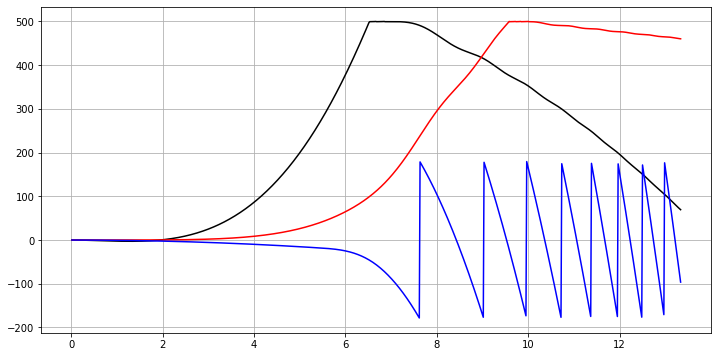

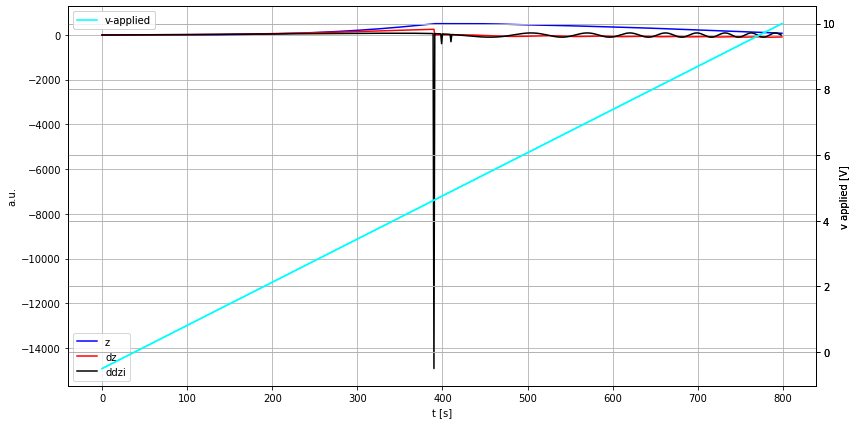

In [609]:

drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])

N = 800 # number of iterations

# Allocating a NumPy array for our data, with N rows and 14 columns, of which 
# 12 column will be used to store drone output, and 2 columns for other data
results = np.zeros([N,14])
V_break = np.linspace(-0.5,10,N)

for i in range(N):
    # each iteration we can set the voltage of the motors
    drone.set_V(V_left + V_break[i], V_left + V_break[i])
    # the update functions performas one iteration of 1/60 s duration and returns the state of the drone
    results[i,0:12] = drone.update()
    results[i,12] = V_break[i]

# Plotting the result
# plt.tight_layout()

t = results[:,0]
y = results[:,1]
z = results[:,2]
v_apply = results[:,12]
phi = results[:,3]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t,z, 'k', label="z")
plt.plot(t,y, 'r', label="y")
plt.plot(t,np.rad2deg(phi), 'b', label="phi")
plt.grid()
plt.show()


# Plotting the result
t = results[:,0]
z = results[:,2]
dz = results[:,5]
ddz = np.diff(dz)/np.diff(t)
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(z, 'b', label="z")
plt.plot(dz, 'r', label="dz")
plt.plot(ddz, 'k', label="ddzi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
# plt.tight_layout()

# t = results[:,0]
# y = results[:,1]
# z = results[:,2]
v_apply = results[:,12]
# phi = results[:,3]
# fig, ax = plt.subplots(1, figsize=(12,6))
# plt.plot(t,z, 'k', label="z")
# plt.plot(t,y, 'r', label="y")
# plt.plot(t,np.rad2deg(phi), 'b', label="phi")


ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.legend()
ax2 = ax.twinx()
plt.plot(v_apply, 'cyan', label="v-applied")
plt.ylabel('v applied [V]')
plt.grid()
plt.legend()
plt.tight_layout()

ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.legend()
ax2 = ax.twinx()
plt.plot(v_apply, 'cyan', label="v-applied")
plt.ylabel('v applied [V]')
plt.grid()
plt.legend()
plt.tight_layout()


In [610]:
idx = np.argmin(ddz)
V_break[idx] + V_right

5.130825001742341

In [639]:
V_max = 5.130825001742341
V_left, V_left

(0.49441855618539365, 0.49441855618539365)

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


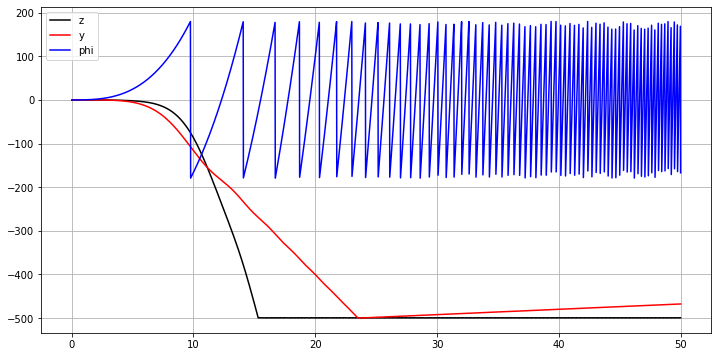

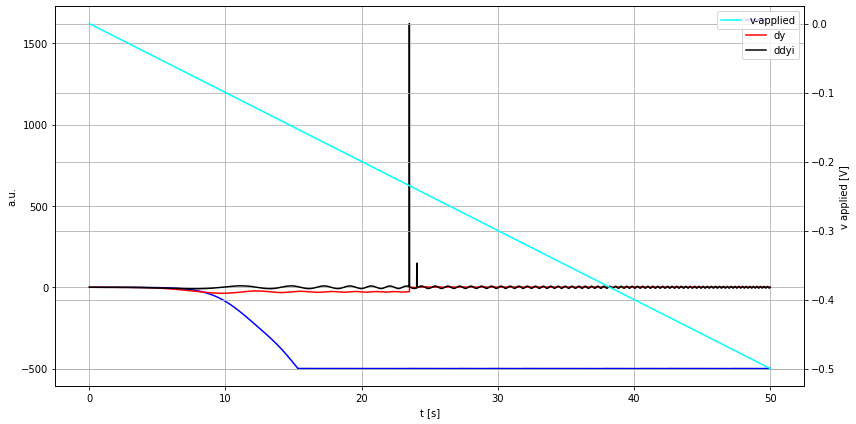

In [657]:

drone = module.Drone(name=MyName, wind=False, flight_range=[-500,-500,500,500])

N = 3000 # number of iterations

# Allocating a NumPy array for our data, with N rows and 14 columns, of which 
# 12 column will be used to store drone output, and 2 columns for other data
results = np.zeros([N,14])

V_break = np.linspace(0,-0.5, N)

for i in range(N):
    # each iteration we can set the voltage of the motors
    drone.set_V(V_left + V_break[i], V_right)
    # the update functions performas one iteration of 1/60 s duration and returns the state of the drone
    results[i,0:12] = drone.update()
    results[i,12] = V_break[i]

# Plotting the result
# plt.tight_layout()

t = results[:,0]
y = results[:,1]
z = results[:,2]
v_apply = results[:,12]
phi = results[:,3]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t,z, 'k', label="z")
plt.plot(t,y, 'r', label="y")
plt.plot(t,np.rad2deg(phi), 'b', label="phi")
plt.grid()
plt.legend()
plt.show()

# Plotting the result
t = results[:,0]
z = results[:,2]
dy = results[:,4]
ddy = np.diff(dy)/np.diff(t)
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t, z, 'b', label="z")
plt.plot(t, dy, 'r', label="dy")
plt.plot(t[:-1], ddy, 'k', label="ddyi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")

plt.grid()
plt.legend()

v_apply = results[:,12]


ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.legend()
ax2 = ax.twinx()
plt.plot(t, v_apply, 'cyan', label="v-applied")
plt.ylabel('v applied [V]')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()


In [663]:
idx = np.argmax(ddy)
V_break[idx]

-0.23491163721240413

In [667]:
V_break[idx] + V_left

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2595069189729895

In [668]:
V_min = 00.2595069189729895

Now we have identified the parameters for our specifc drone. Let's print then so that we can copy and paste the values as variables into the next notebooks for the drone controls.

In [669]:
print(f"V_left_offset = {V_left_offset}")
print(f"V_hover = {V_hover}")
print(f"V_max = {V_max}")
print(f"V_min = {V_min}")

V_left_offset = -0.011250000000001564
V_hover = (0.49441855618539365, 0.5056685561853952)
V_max = 5.130825001742341
V_min = 0.2595069189729895
